# filter temporally surface fields abd geographically average energies


In [1]:
import os

import numpy as np
import xarray as xr

from scipy import signal

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs

import mitequinox.utils as ut
import mitequinox.plot as pl
import mitequinox.sigp as sp

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #w = cluster.scale(jobs=15)
    w = cluster.scale(jobs=5)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.255:46004 Dashboard: http://10.148.0.255:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---

## define the filter and utils

In [4]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K1")
omega, domega, name = tidal_omega["M2"], .2, "semidiurnal"
T=10

h = sp.generate_filter(omega, T=T, dt=dt, bandwidth=domega, normalized_bandwidth=None)
h_hat, w = sp.filter_response(h, dt=dt)

No handles with labels found to put in legend.


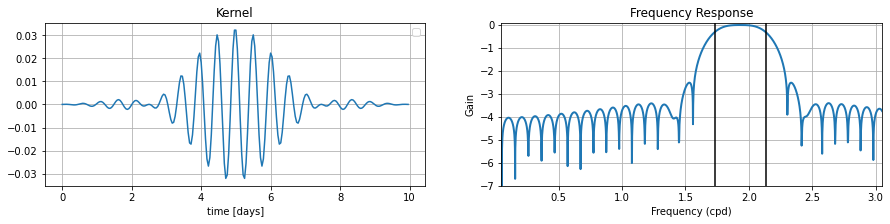

In [5]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
t = np.arange(0, h.size)*dt
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-domega, color='k')
ax.axvline(omega+domega, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

In [6]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1)
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False, subsample=1):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    out = xr.apply_ufunc(convolve, v, 
                    kwargs={'h': h, 'hilbert': hilbert,},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )
    out = out.isel(time=slice(0,None,subsample))
    return out

---

## process full dataset and store

In [7]:
def load_rechunked(v, grid=True, dij=None):
    zarr = os.path.join(ut.work_data_dir, "rechunked/{}.zarr".format(v))
    ds = xr.open_zarr(zarr).chunk({"time": -1})
    if v=="SSU":
        ds = ds.rename({"i_g": "i"})
    elif v=="SSV":
        ds = ds.rename({"j_g": "j"})
    #
    if dij is not None:
        ds = ds.isel(i=slice(0,None, dij), j=slice(0,None, dij))
    #
    if grid:
        grd = ut.load_grd()[['XC', 'YC', 'Depth']]
        ds = ds.merge(grd, join="inner")
    return ds

In [15]:
def filt_fun(da):
    return abs(filt(da, h, hilbert=True, subsample=24))

for v in ["Eta", "SSU", "SSV"]:
    
    ds = load_rechunked(v, dij=2)
    ds_hat, Z = ut.custom_distribute(ds[v], filt_fun, face=3)
    
    #ds_hat.to_zarr(os.path.join(ut.scratch, "".format(v)), mode="w")
    ut.store_diagnostic("bpassed_{}_abs_{}".format(name, v), ds_hat, overwrite=True)

data stored in /home/datawork-lops-osi/equinox/mit4320/diags/bpassed_semidiurnal_abs_Eta.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/bpassed_semidiurnal_abs_SSU.zarr
data stored in /home/datawork-lops-osi/equinox/mit4320/diags/bpassed_semidiurnal_abs_SSV.zarr


---

## load and bin average

In [7]:
ds = xr.merge([ut.load_diagnostic("bpassed_{}_abs_{}".format(name, v)) for v in ["Eta", "SSU", "SSV"]])
ds = ds.isel(time=slice(T,-T))

In [8]:
deep = ds.where(ds.Depth>500).mean(["face", "i", "j"]).persist()
shallow = ds.where(ds.Depth<500).mean(["face", "i", "j"]).persist()

### deep

Text(0, 0.5, 'sqrt(u^2+v^2)')

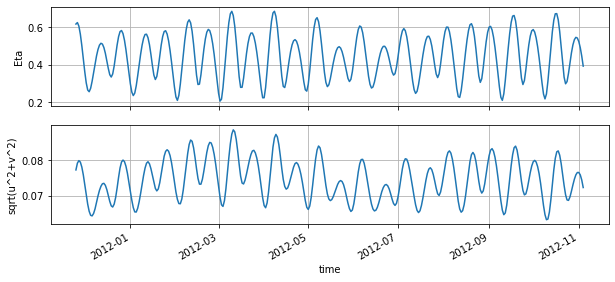

In [19]:
_ds = deep

fig, axes = plt.subplots(2,1, figsize=(10, 4))

ax = axes[0]
_ds["Eta"].plot(ax=ax)
ax.set_xticklabels([])
ax.grid()
ax.set_xlabel("")

ax = axes[1]
np.sqrt(_ds["SSU"]**2+_ds["SSV"]**2).plot(ax=ax)
#_ds["SSV"].plot(ax=ax)
#ax.set_xticklabels([])
ax.grid()
ax.set_ylabel("sqrt(u^2+v^2)")

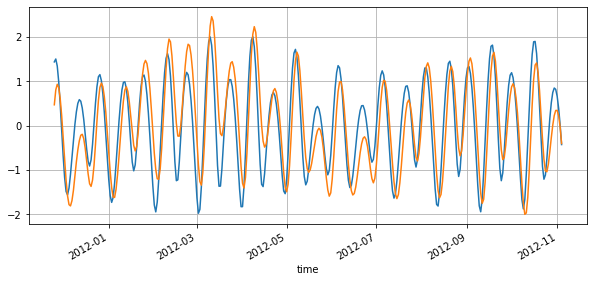

In [32]:
_ds = deep

fig, ax = plt.subplots(1,1, figsize=(10, 4))

((_ds["Eta"]-_ds["Eta"].mean())/_ds["Eta"].std() ).plot(ax=ax, label="Eta")
_u = np.sqrt(_ds["SSU"]**2+_ds["SSV"]**2)
((_u-_u.mean())/_u.std() ).plot(ax=ax, label="sqrt(u^2+v^2)")
ax.grid()

### shallow

Text(0, 0.5, 'sqrt(u^2+v^2)')

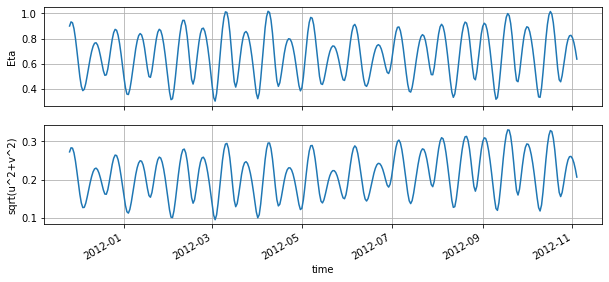

In [20]:
_ds = shallow

fig, axes = plt.subplots(2,1, figsize=(10, 4))

ax = axes[0]
_ds["Eta"].plot(ax=ax)
ax.set_xticklabels([])
ax.grid()
ax.set_xlabel("")

ax = axes[1]
np.sqrt(_ds["SSU"]**2+_ds["SSV"]**2).plot(ax=ax)
#_ds["SSV"].plot(ax=ax)
#ax.set_xticklabels([])
ax.grid()
ax.set_ylabel("sqrt(u^2+v^2)")

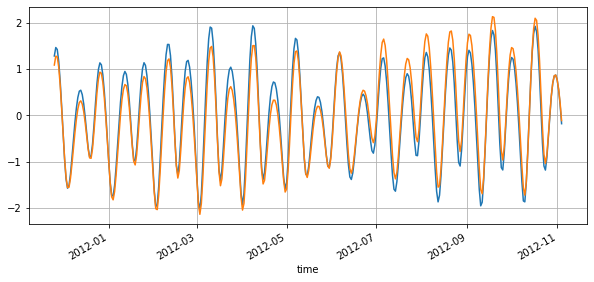

In [33]:
_ds = shallow

fig, ax = plt.subplots(1,1, figsize=(10, 4))

((_ds["Eta"]-_ds["Eta"].mean())/_ds["Eta"].std() ).plot(ax=ax, label="Eta")
_u = np.sqrt(_ds["SSU"]**2+_ds["SSV"]**2)
((_u-_u.mean())/_u.std() ).plot(ax=ax, label="sqrt(u^2+v^2)")
ax.grid()

### zonal average

In [21]:
from xhistogram.xarray import histogram

In [23]:
dl = 1.
lat_bins = np.arange(-60, 60, dl)

def bin_average(ds):

    ds['lat_3d'] = 0*ds.face+ds.YC
    ds['lat_4d'] = 0*ds.SSU+ds.YC    
    
    N = histogram(ds.lat_3d.rename('lat'), bins=[lat_bins], 
                  dim=['i', 'j', 'face']
                 ).persist()

    E = {}
    for v in ["Eta", "SSU", "SSV"]:
        _E = histogram(ds.lat_4d.rename('lat'), bins=[lat_bins], 
                      weights=ds[v],
                      dim=['i', 'j', 'face']
                     )
        E[v] = (_E/N).rename(v).persist()

    return E, N

In [24]:
deep_bin, deep_N = bin_average(ds.where(ds.Depth>500))

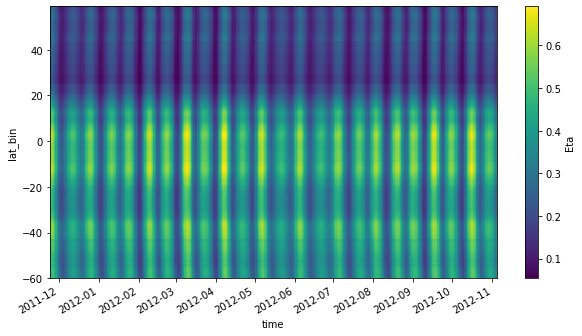

In [25]:
deep_bin["Eta"].plot(x="time", figsize=(10, 5))

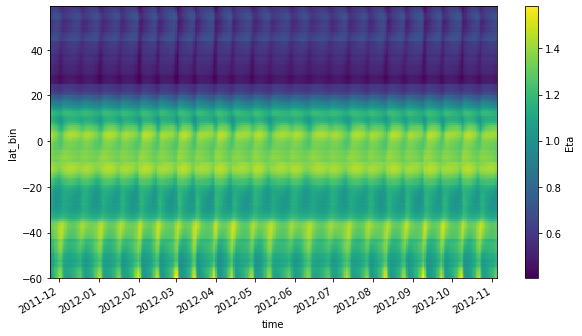

In [34]:
(deep_bin["Eta"]/deep_bin["Eta"].mean("lat_bin")).plot(x="time", figsize=(10, 5))

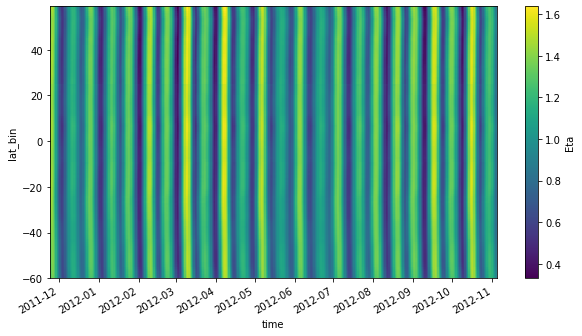

In [36]:
(deep_bin["Eta"]/deep_bin["Eta"].mean("time")).plot(x="time", figsize=(10, 5))

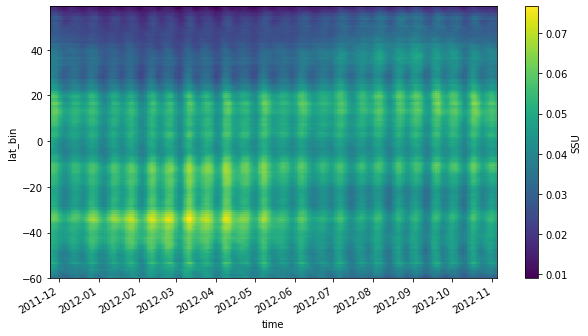

In [26]:
deep_bin["SSU"].plot(x="time", figsize=(10, 5))

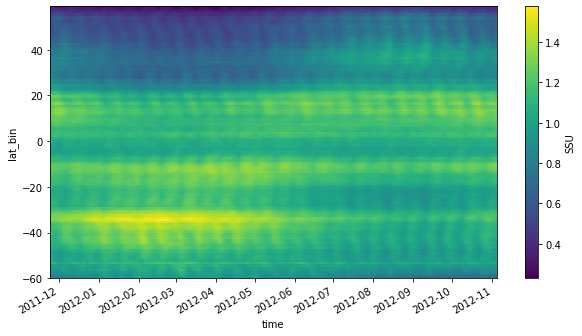

In [35]:
(deep_bin["SSU"]/deep_bin["SSU"].mean("lat_bin")).plot(x="time", figsize=(10, 5))

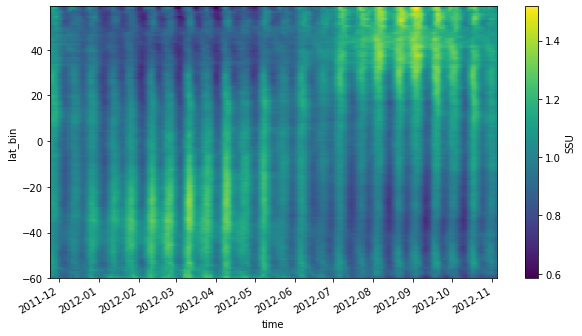

In [37]:
(deep_bin["SSU"]/deep_bin["SSU"].mean("time")).plot(x="time", figsize=(10, 5))

---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [ ]:
cluster.close()